# ECU Analysis

## Setup

In [2]:
import sys
print(sys.version)

3.12.4 | packaged by Anaconda, Inc. | (main, Jun 18 2024, 15:03:56) [MSC v.1929 64 bit (AMD64)]


### Import packages

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import linprog, milp, LinearConstraint, Bounds
import os
from pathlib import Path
import itertools
import re
from numpy.typing import ArrayLike
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Data Loading Helper Function

In [2]:
# HVAC data to Pandas
def read_multiple_tables(file_path):
    """
    Reads a CSV string with multiple tables separated by blank lines 
    into a list of Pandas DataFrames.

    Args:
        csv_string (str): The CSV data as a string.

    Returns:
        list: A list of Pandas DataFrames, one for each table.  
              Returns an empty list if no tables are found or if an error occurs.
    """
    rows = []
    current_ecu_config = None
    current_shelter = None
    current_header = None
    current_subtable = None
    current_source = None

    first = True

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            stripped = line.strip().strip(",")\
            
            if not stripped:  # blank line → table break
                continue

            # If this is a shelter name row
            if stripped.startswith("24 Profile for Shelter") or stripped.startswith("\ufeff24 Profile for Shelter"):
                split_str = stripped.split(" ")
                current_ecu_config = split_str[-1]
                current_shelter = ' '.join(split_str[-3:-1])
                current_header = None
                continue

            # Detect subtable title (row without commas or with commas only at end)
            if not "," in stripped:
                current_subtable = stripped
                current_header = None
                continue

            # If this is a header row (contains commas and no table header yet)
            if current_header is None:
                current_header = stripped.split(",")
                current_header.insert(0, "RowName")
                continue

            # Otherwise, it's a data row
            row_data = stripped.split(",")
            row_dict = {
                "ShelterName": current_shelter,
                "ECUConfig": current_ecu_config,
                "SubTableName": current_subtable,
                "RowName": row_data[0]
            }
            row_dict.update(dict(zip(current_header, row_data)))
            rows.append(row_dict)

    # Combine into DataFrame and Return
    return pd.DataFrame(rows)

### Read in data from CSVs

In [24]:
# Filenames
# taiw_hvac_filename = "Inputs/HVAC24HourProfile_Taiwan.csv"
ecu_data_filename = "Inputs/ECUSpecs.csv"

directory = "Inputs"
filename = "HVAC24HourProfile_Palms_Custom.csv"

palm_hvac_df = read_multiple_tables(Path(directory, filename))
# taiw_hvac_df = read_multiple_tables(Path(taiw_hvac_filename))
# palm_power_df = pd.read_csv(Path(palm_power_filename))
# taiw_power_df = pd.read_csv(Path(taiw_power_filename))
catalog_df = pd.read_csv(Path(ecu_data_filename))

# Convert temperature cols to numeric
palm_hvac_df.iloc[:,4:] = palm_hvac_df.iloc[:,4:].apply(pd.to_numeric)
# taiw_hvac_df.iloc[:,4:] = taiw_hvac_df.iloc[:,4:].apply(pd.to_numeric)

# Rename ecu_specs column names
catalog_df = catalog_df.rename(columns={"Unit (ECU)": "Model", 
                                            "Cooling Capacity (BTU/hr)": "CapacityBTU", 
                                            "Cooling Load (kVA)": "PowerKVA", 
                                            "Cost": "CostUSD"})

### HVAC Computation Helpers

In [ ]:
# ==============================
# USER SETTINGS
# ==============================
CATALOG_PATH = "Inputs/ECUSpecs.csv"
DEMAND_TARGET = "peak"              # 'peak', 'sum', or e.g. 'p95'
N_PLUS_ONE = True                   # Add an extra unit for redundancy
ELECTRICITY_RATE_USD_PER_KWH = 0.0  # ignored if 0
LAMBDA_OP_COST = 0.0                # weighting for op cost in objective
MAX_QTY_PER_MODEL = 5               # search limit per unit type

# ==============================
# FUNCTIONS
# ==============================


def extract_btu_demand(df):
    # Identify columns that represent hourly BTU values (numeric column headers)
    # time_cols = [c for c in df.columns if c.strip().isdigit()]
    time_cols = list(range(4,28))
    
    # Filter to the rows that contain the HVAC Heat Load summary
    hvac_rows = df[(df['SubTableName'].str.contains('Shelter HVAC Heat Load')) & 
                   (df['RowName']).str.contains('Shelter HVAC Heat Load')].copy()
    
    # Calculate row-wise peak BTU across all hours
    hvac_rows["PeakBTU"] = hvac_rows.iloc[:,4:].max(axis=1)
    
    return_cols = ['ShelterName', 'ECUConfig', 'SubTableName', 'RowName', 'PeakBTU']

    return hvac_rows.loc[:,return_cols]

def compute_demand_targets(df_btu):
    if DEMAND_TARGET == "peak":
        return df_btu.groupby("ShelterName")["PeakBTU"].max().rename("TargetBTU").reset_index()
    elif DEMAND_TARGET.startswith("p") and DEMAND_TARGET[1:].isdigit():
        perc = int(DEMAND_TARGET[1:])
        return (
            df_btu.groupby("ShelterName")["PeakBTU"]
            .quantile(perc / 100)
            .rename("TargetBTU")
            .reset_index()
        )

# ==============================
# Extract demand and targets
# ==============================

palm_btu = extract_btu_demand(palm_hvac_df)
# taiw_btu = extract_btu_demand(taiw_hvac_df)

palm_targets = compute_demand_targets(palm_btu)
# taiw_targets = compute_demand_targets(taiw_btu)

### Helper Function to Load ECU Catelog

In [ ]:
DEFAULT_PF = 1.0  # Consumer power factor default

def load_catalog_with_kva(df) -> pd.DataFrame:
    """
    Load ECU catalog that may list power as kVA (and optionally PF).
    Produces: Model, CapacityBTU, PowerKW, CostUSD
    Priority for PowerKW:
      1) explicit PowerKW column
      2) PowerKVA * PF  (PF from column if present, else DEFAULT_PF)
      3) computed from Volts/Amps (1φ or 3φ) * PF
    """
    # df = pd.read_csv(path)

    # Normalize headings
    cmap = {}
    for c in df.columns:
        lc = c.lower().strip()
        if "model" in lc:                           cmap[c] = "Model"
        elif "capacity" in lc and "btu" in lc:      cmap[c] = "CapacityBTU"
        elif "power" in lc and "kw" in lc:          cmap[c] = "PowerKW"
        elif "kva" in lc:                           cmap[c] = "PowerKVA"
        elif lc in ("pf", "power factor"):          cmap[c] = "PF"
        elif "cost" in lc or "price" in lc:         cmap[c] = "CostUSD"
        elif "volt" in lc:                          cmap[c] = "Volts"
        elif "amp" in lc or "current" in lc:        cmap[c] = "Amps"
        elif "phase" in lc:                         cmap[c] = "Phase"
        elif "weight" in lc:                        cmap[c] = "Weight"
        elif "size" in lc:                          cmap[c] = "Size"
    df = df.rename(columns=cmap)

    # Basic required columns
    req_base = ["Model", "CapacityBTU", "CostUSD", "Weight", "Size"]
    missing = [r for r in req_base if r not in df.columns]
    if missing:
        raise ValueError(f"Catalog missing required columns {missing}. Found: {list(df.columns)}")

    out = df.copy()
    out["CapacityBTU"] = pd.to_numeric(out["CapacityBTU"], errors="coerce")
    out["CostUSD"]     = pd.to_numeric(out["CostUSD"], errors="coerce")

    # 1) If PowerKW already provided, use it
    power_kw = None
    if "PowerKW" in out.columns:
        power_kw = pd.to_numeric(out["PowerKW"], errors="coerce")

    # 2) Else derive from kVA * PF (PF column if present, else DEFAULT_PF)
    if power_kw is None or power_kw.isna().all():
        pf = out["PF"] if "PF" in out.columns else DEFAULT_PF
        # pf = pd.to_numeric(pf, errors="coerce").fillna(DEFAULT_PF)

        if "PowerKVA" in out.columns:
            kva = pd.to_numeric(out["PowerKVA"], errors="coerce")
            power_kw = kva * pf

    # 3) Else derive from Volts/Amps (if available), assuming PF
    if (power_kw is None) or power_kw.isna().all():
        if "Volts" in out.columns and "Amps" in out.columns:
            V  = pd.to_numeric(out["Volts"], errors="coerce")
            I  = pd.to_numeric(out["Amps"],  errors="coerce")
            pf = out["PF"] if "PF" in out.columns else DEFAULT_PF
            pf = pd.to_numeric(pf, errors="coerce").fillna(DEFAULT_PF)

            # detect phase (defaults to single-phase if unknown)
            if "Phase" in out.columns:
                phase_num = out["Phase"].astype(str).str.extract(r"(\d+)").astype(float).squeeze()
            else:
                phase_num = pd.Series(np.nan, index=out.index)

            is_3ph = phase_num.eq(3).fillna(False)
            kva_est = pd.Series(np.nan, index=out.index, dtype=float)
            kva_est[is_3ph]  = (np.sqrt(3) * V[is_3ph] * I[is_3ph]) / 1000.0
            kva_est[~is_3ph] = (V[~is_3ph] * I[~is_3ph]) / 1000.0

            power_kw = kva_est * pf

    if power_kw is None or power_kw.isna().all():
        raise ValueError("Could not determine PowerKW (no PowerKW, no PowerKVA+PF, and no Volts/Amps).")

    out["PowerKW"] = power_kw

    # Final clean & checks
    needed = ["Model", "CapacityBTU", "PowerKW", "CostUSD", "Weight", "Size"]
    bad = out[needed].isnull().any(axis=1)
    if bad.any():
        raise ValueError(f"Some rows have missing numeric values after conversion:\n{out.loc[bad, needed]}")

    return out[needed].reset_index(drop=True)


### MILP with Normalization

In [ ]:
def optimize_ecu_mix(
    targets_df: pd.DataFrame,
    catalog_df: pd.DataFrame,
    *,
    weights: dict | None = None,      # {"cost":..., "power":..., "weight":..., "size":...}
    btu_penalty: float = 1.0,         # penalty multiplier on normalized overshoot
    shelter_col: str = "ShelterName", # ID column
    target_col: str = "TargetBTU",    # demand column
) -> pd.DataFrame:
    """
    MILP for ECU allocation with automatic normalization of objective terms.
    - Cost, power, weight, size scaled to [0,1] by catalog max
    - Excess BTU normalized as fraction of target demand
    """
    if weights is None:
        weights = {"cost": 1.0, "power": 1.0, "weight": 1.0, "size": 1.0}

    shelters = (targets_df[[shelter_col, target_col]]
                .dropna()
                .groupby(shelter_col, as_index=False)[target_col].max())
    shelter_names = shelters[shelter_col].astype(str).tolist()
    S = len(shelter_names)

    cat = catalog_df[["Model", "CapacityBTU", "PowerKW", 
                      "CostUSD", "Weight", "Size"]].copy()
    cat["Model"] = cat["Model"].astype(str)
    models = cat["Model"].tolist()
    M = len(models)

    cap   = cat["CapacityBTU"].to_numpy(float)
    cost  = cat["CostUSD"].to_numpy(float)
    kw    = cat["PowerKW"].to_numpy(float)
    wt    = cat["Weight"].to_numpy(float)
    sz    = cat["Size"].to_numpy(float)

    # ----------------------------
    # Normalization
    # ----------------------------
    cost_scale  = cost.max()   if cost.max()   > 0 else 1.0
    kw_scale    = kw.max()     if kw.max()     > 0 else 1.0
    wt_scale    = wt.max()     if wt.max()     > 0 else 1.0
    sz_scale    = sz.max()     if sz.max()     > 0 else 1.0

    norm_cost   = cost / cost_scale
    norm_kw     = kw   / kw_scale
    norm_wt     = wt   / wt_scale
    norm_sz     = sz   / sz_scale

    # Weight multipliers
    w_cost   = float(weights.get("cost",   1.0))
    w_power  = float(weights.get("power",  1.0))
    w_weight = float(weights.get("weight", 1.0))
    w_size   = float(weights.get("size",   1.0))

    def idx_x(s_idx, m_idx): return s_idx * M + m_idx
    def idx_e(s_idx):        return S * M + s_idx

    n_vars = S * M + S

    # ----------------------------
    # Objective coefficients
    # ----------------------------
    c = np.zeros(n_vars, dtype=float)
    for s_idx in range(S):
        for m_idx in range(M):
            j = idx_x(s_idx, m_idx)
            c[j] = (w_cost   * norm_cost[m_idx] +
                    w_power  * norm_kw[m_idx]   +
                    w_weight * norm_wt[m_idx]   +
                    w_size   * norm_sz[m_idx])
        # Normalize excess penalty by target demand
        target = float(shelters.iloc[s_idx][target_col])
        norm_penalty = btu_penalty / (target if target > 0 else 1.0)
        c[idx_e(s_idx)] = norm_penalty

    # ----------------------------
    # Constraints
    # ----------------------------
    rows = []
    ub   = []
    for s_idx, s_name in enumerate(shelter_names):
        target = float(shelters.loc[shelters[shelter_col] == s_name, target_col].iloc[0])
        row = np.zeros(n_vars)
        for m_idx in range(M):
            row[idx_x(s_idx, m_idx)] = -cap[m_idx]
        rows.append(row)
        ub.append(-target)

    for s_idx, s_name in enumerate(shelter_names):
        target = float(shelters.loc[shelters[shelter_col] == s_name, target_col].iloc[0])
        row = np.zeros(n_vars)
        for m_idx in range(M):
            row[idx_x(s_idx, m_idx)] = cap[m_idx]
        row[idx_e(s_idx)] = -1.0
        rows.append(row)
        ub.append(target)

    A = np.vstack(rows)
    lc = LinearConstraint(A, lb=-np.inf*np.ones(A.shape[0]), 
                          ub=np.array(ub, dtype=float))

    bounds = Bounds(lb=np.zeros(n_vars), ub=np.full(n_vars, np.inf))
    integrality = np.zeros(n_vars, dtype=int)
    integrality[:S*M] = 1

    # ----------------------------
    # Solve MILP
    # ----------------------------
    res = milp(c=c, integrality=integrality, bounds=bounds, constraints=[lc])
    if res.status != 0:
        raise RuntimeError(f"MILP failed: {res.message}")

    x = res.x
    x[:S*M] = np.maximum(0, np.rint(x[:S*M]).astype(int))
    x[S*M:] = np.maximum(0.0, x[S*M:])

    # ----------------------------
    # Collect results
    # ----------------------------
    out_rows = []
    for s_idx, s_name in enumerate(shelter_names):
        target = float(shelters.iloc[s_idx][target_col])
        mix = {}
        total_btu, total_kw, total_cost, total_wt, total_sz = 0, 0, 0, 0, 0
        for m_idx, m in enumerate(models):
            qty = int(round(x[idx_x(s_idx, m_idx)]))
            if qty > 0:
                mix[m] = qty
                total_btu += qty * cap[m_idx]
                total_kw  += qty * kw[m_idx]
                total_cost+= qty * cost[m_idx]
                total_wt  += qty * wt[m_idx]
                total_sz  += qty * sz[m_idx]

        excess = max(0.0, total_btu - target)

        # Recompute normalized objective value
        obj_val = (w_cost   * (total_cost / cost_scale) +
                   w_power  * (total_kw   / kw_scale)   +
                   w_weight * (total_wt   / wt_scale)   +
                   w_size   * (total_sz   / sz_scale)   +
                   btu_penalty * (excess / target if target > 0 else 0.0))

        out_rows.append({
            "Shelter": s_name,
            "TargetBTU": target,
            "AchievedBTU": total_btu,
            "ExcessBTU": excess,
            "TotalKW": total_kw,
            "TotalCost": total_cost,
            "TotalWeight": total_wt,
            "TotalSize": total_sz,
            "ObjectiveValue": obj_val,
            "ECU_Mix": mix
        })

    return pd.DataFrame(out_rows)

## Run MILP Optimization

Change `weights` and `btu_penalty` as desired based on priorities
- `cost`: Total cost of the ECUs
- `power`: Total amount of electrical load produced by the ECUs
- `weight`: Total weight of the ECUs (lbs)
- `size`: Total size of the ECUs (cubic feet)
- `btu_penalty`: Penalty applied to the solution score based on how many BTUs are produced over the target.

Higher numbers will make it prioritize minimization of that parameter. For example: a high `cost` weight will prioritize a low-cost solution while sacrificing in `power`, `weight`, and `size`

Examples:
- `weights={"cost": 1, "power": 1, "weight": 1, "size": 1}, btu_penalty=1`: Prioritize 60k ECU for all cases
- `weights={"cost": 5, "power": 1, "weight": 4, "size": 3}, btu_penalty=2`: Mixed bag based on the shelter

In [74]:
#####################
# Run Optimization
#####################

catalog_df = load_catalog_with_kva(catalog_df)

solution = optimize_ecu_mix(
    targets_df=palm_targets,
    catalog_df=catalog_df,
    weights={"cost": 5, "power": 1, "weight": 4, "size": 3},
    btu_penalty=2
)

# print(solution)
solution

,Shelter,TargetBTU,AchievedBTU,ExcessBTU,TotalKW,TotalCost,TotalWeight,TotalSize,ObjectiveValue,ECU_Mix
0,AirBeam 2032,58365.0,72000.0,13635.0,21.1,22000.00,540.0,30.18,12.195036,{'HDT': 1}
1,AirBeam 3236,77883.0,90000.0,12117.0,26.2,32020.66,770.0,39.88,16.802189,"{'18K': 1, 'HDT': 1}"
2,Base-X 203,48526.0,60000.0,11474.0,12.9,20251.00,560.0,48.40,12.686776,{'60K': 1}
3,Base-X 305,59336.0,72000.0,12664.0,21.1,22000.00,540.0,30.18,12.154661,{'HDT': 1}


## Pretty Graphs

#### Setup for graphing

In [ ]:
location = "Twentynine Palms"

# Melt into long format
melted = palm_hvac_df.melt(
    id_vars=["ShelterName", "ECUConfig", "SubTableName", "RowName"],
    var_name="Time", value_name="Value"
).drop_duplicates(subset=['ShelterName', 'ECUConfig', 'SubTableName', 
                          'RowName', 'Time'])

# Clean up Time axis (use start hour only)
melted["Hour"] = melted["Time"].str.extract(r"(\d{2})(?=00)")
melted["Hour"] = pd.to_numeric(melted["Hour"], errors="coerce")

# Clean up value axis
melted["Value"] = pd.to_numeric(melted["Value"], errors="coerce")

# Use colorblind-friendly style
sns.set_theme(style="whitegrid", palette="colorblind")

#### Solution Graphs

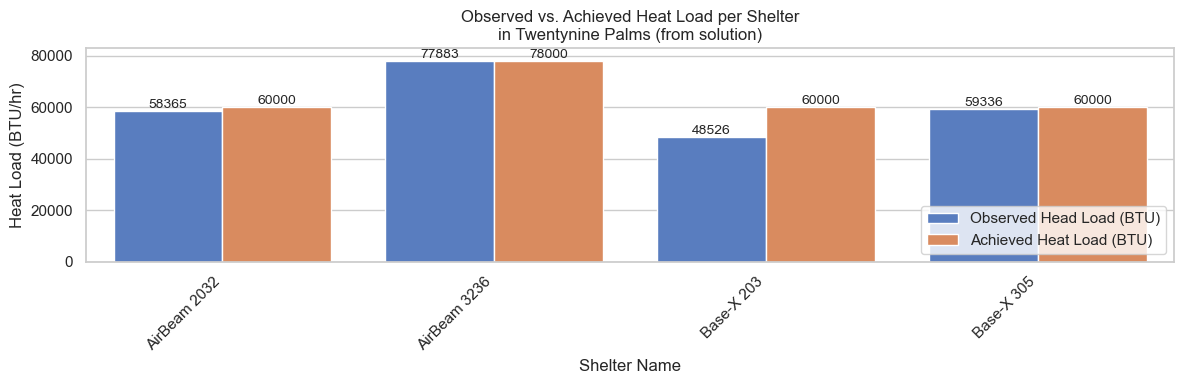

In [ ]:
# --------------------------
# 1. Solution Sufficiency Graph
# --------------------------

# Compute max HVAC load per shelter from palm_hvac_df
max_loads = (
    melted[melted["RowName"] == "Shelter HVAC Heat Load"]
    .groupby("ShelterName")["Value"]
    .max()
    .reset_index(name="Max_Observed_Load")
)

# Merge solution and max loads
solution = solution.rename(columns={'Shelter': 'ShelterName'})
comparison_df = max_loads.merge(solution, on="ShelterName")
comparison_df

# Reshape for seaborn
comparison_melted = comparison_df.melt(
    id_vars="ShelterName",
    value_vars=["Max_Observed_Load", "AchievedBTU"],
    var_name="Source",
    value_name="Max_Load"
)
name_mapping = {
    "Max_Observed_Load": "Observed Head Load (BTU)",
    "AchievedBTU": "Achieved Heat Load (BTU)"
}
comparison_melted['Source'] = comparison_melted['Source'].map(name_mapping)

# Plot with seaborn
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    data=comparison_melted,
    x="ShelterName", y="Max_Load", hue="Source",
    palette="muted", dodge=True
)

# Plot labeling/settings
plt.ylabel("Heat Load (BTU/hr)")
plt.xlabel("Shelter Name")
plt.title(f"Observed vs. Achieved Heat Load per Shelter\nin {location} (from solution)")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="lower right")
ax.set_ylim(0, (comparison_melted["Max_Load"].max() + 5000))

# Add bar labels
[ax.bar_label(container, fontsize=10) for container in ax.containers]

plt.tight_layout()
plt.show()

#### Heat Load Type Graphs

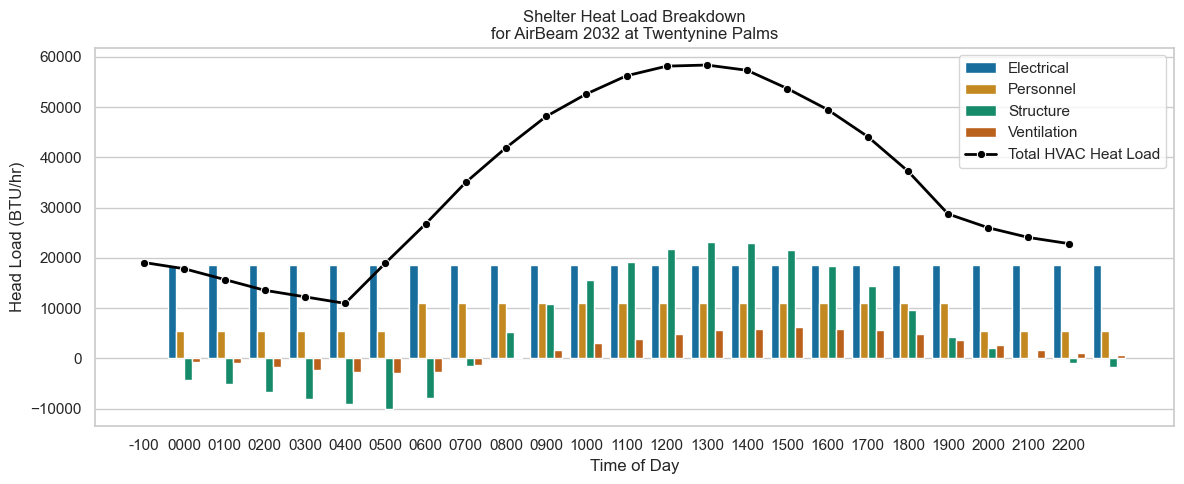

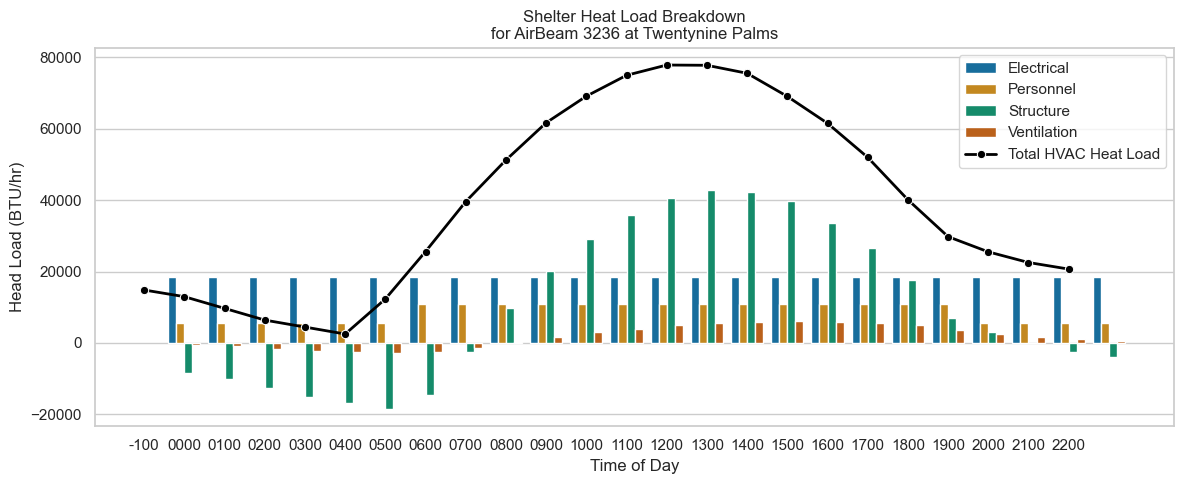

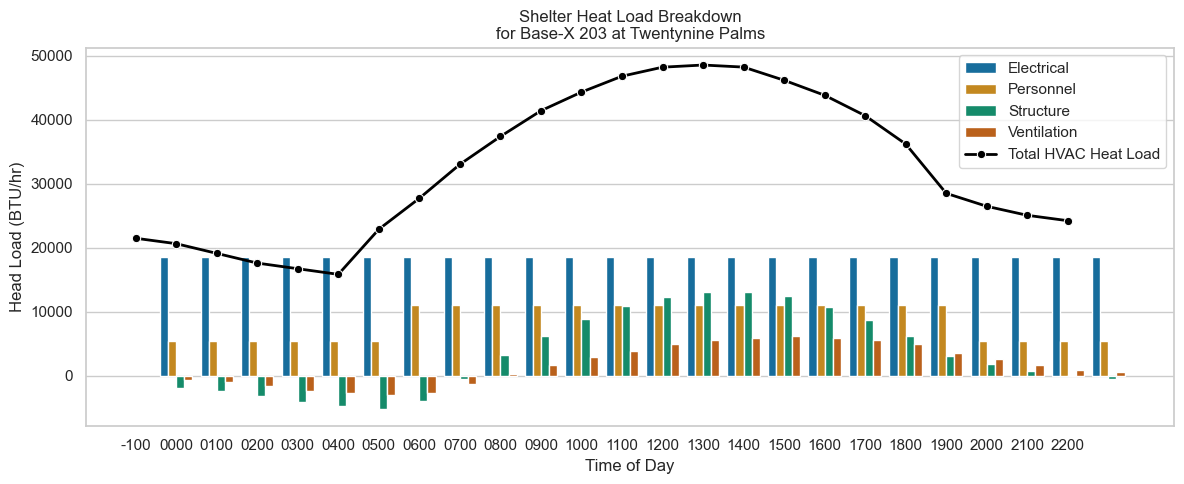

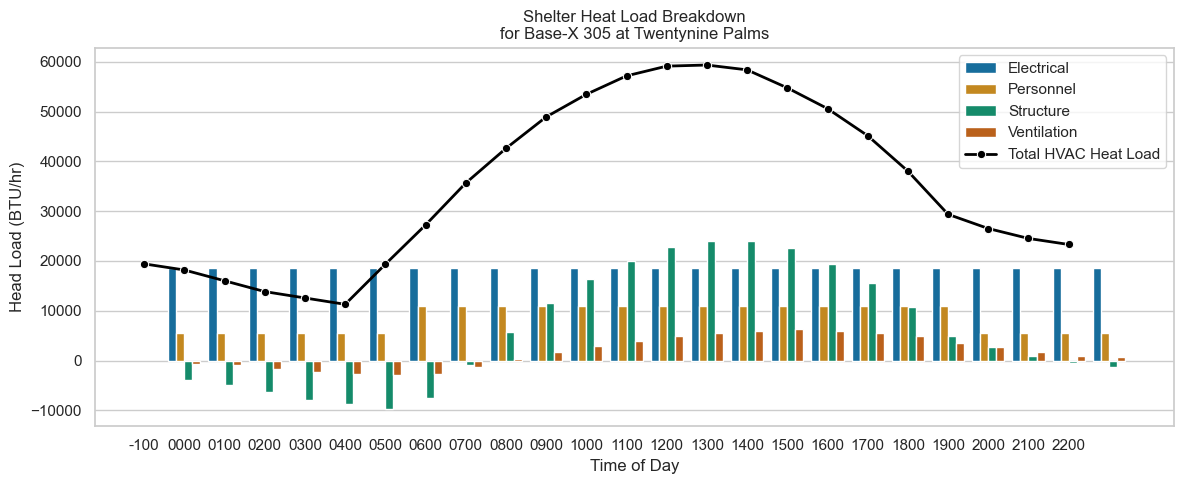

In [44]:
# --------------------------
# 2. Heat load types
# --------------------------

for shelter_name in palm_hvac_df['ShelterName'].unique():
    plt.figure(figsize=(12, 5))
    
    hvac_load_df = melted[(melted["RowName"] == "Shelter HVAC Heat Load") & 
                          (melted["ShelterName"] == shelter_name)].drop_duplicates(subset=("ShelterName", "Hour"))
    hvac_load_df["Hour"] = hvac_load_df["Hour"] - 1
    source_df = melted[melted["RowName"].isin(["Structure", "Ventilation", 
                                            "Personnel", "Electrical"])].drop_duplicates(subset=['Hour', 'RowName', 'ShelterName'])
    source_df = source_df[source_df['ShelterName'] == shelter_name]
    # source_df["Hour"] = source_df["Hour"] + 1

    sns.set_theme(style="whitegrid", palette="colorblind")

    # Multiple bar plot
    bottoms = pd.Series([0] * 24)
    ax = sns.barplot(
        data=source_df,
        x="Hour",
        y="Value",
        hue="RowName",
        # dodge=True
    )


     # Overlay HVAC Load line
    sns.lineplot(data=hvac_load_df, x="Hour", y="Value",
                 color="black", marker="o", linewidth=2, 
                 label="Total HVAC Heat Load", ax=ax)
    


    # Format axes
    plt.ylabel("Head Load (BTU/hr)")
    plt.xlabel("Time of Day")
    plt.title(f"Shelter Heat Load Breakdown\nfor {shelter_name} at {location}")
    plt.xticks(hvac_load_df["Hour"], [f"{h:02d}00" for h in hvac_load_df["Hour"]])
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Temperature Graphs

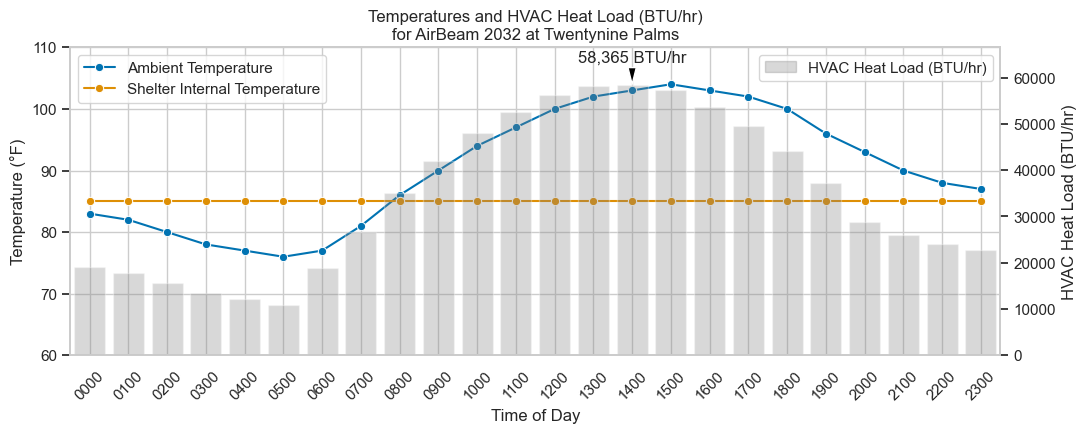

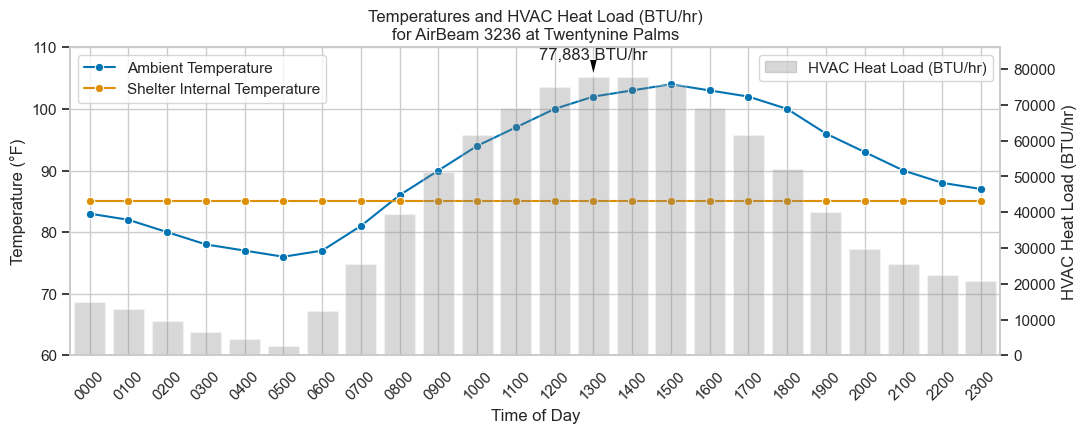

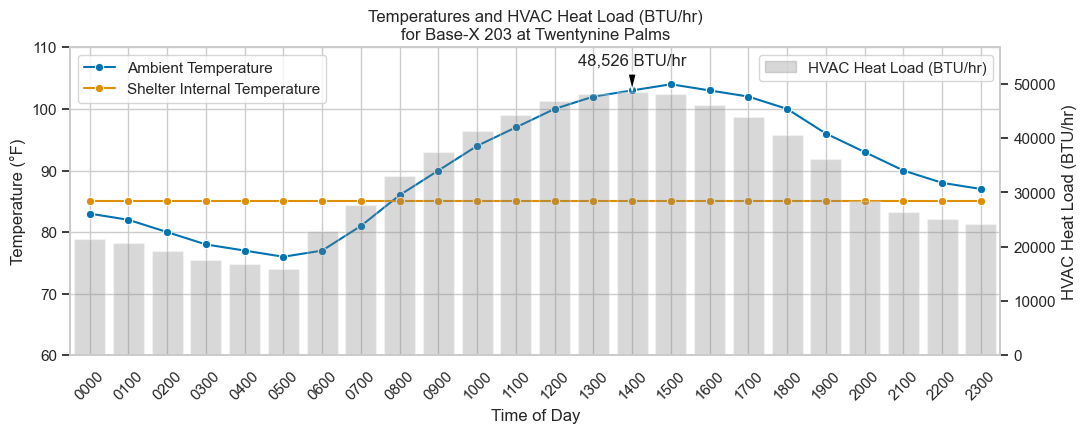

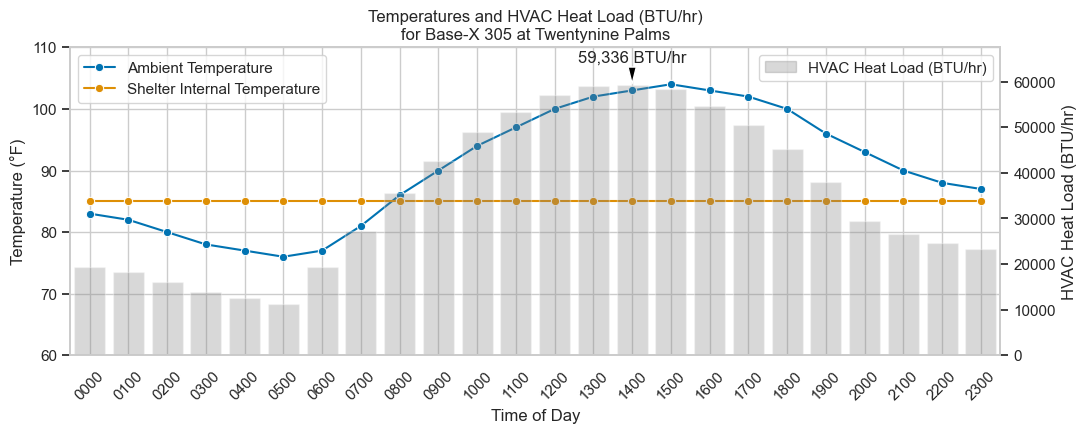

In [63]:
# --------------------------
# 3. Temperatures
# --------------------------

# Melt dfs
melted["Hour"] = melted["Hour"].replace(24, 0)
temp_df = melted[melted["RowName"].isin(["Ambient Temperature", "Shelter Internal Temperature"])].drop_duplicates(subset=['Hour', 'RowName', 'ShelterName'])



# Make graphs
for shelter_name in palm_hvac_df['ShelterName'].unique():
    temp_df2 = temp_df[temp_df['ShelterName'] == shelter_name]
    # temp_df["Hour"] = temp_df["Hour"] # Align temperatures with bar plots
    hvac_load_df = melted[(melted["RowName"] == "Shelter HVAC Heat Load") & 
                        (melted["ShelterName"] == shelter_name)].drop_duplicates(subset=("ShelterName", "Hour"))
    
    plt.figure(figsize=(12, 4))

    # Primary y-axis: temperatures
    ax1 = sns.lineplot(data=temp_df2, x="Hour", y="Value", hue="RowName", marker="o")
    ax1.set_title(f"Temperatures and HVAC Heat Load (BTU/hr)\nfor {shelter_name} at {location}")
    ax1.set_ylabel("Temperature (°F)")
    ax1.set_xlabel("Time of Day")

    # Secondary y-axis: HVAC Heat Load
    ax2 = ax1.twinx()
    sns.barplot(data=hvac_load_df, x="Hour", y="Value", alpha=0.3, color="gray", ax=ax2)
    ax2.set_ylabel("HVAC Heat Load (BTU/hr)")


    # Find max HVAC load
    max_idx = hvac_load_df["Value"].idxmax()
    max_hour = hvac_load_df.loc[max_idx, "Hour"]
    max_value = hvac_load_df.loc[max_idx, "Value"]

    # Set axis limits
    ax1.set_ylim(60, 110)   # Fixed range y-axis
    ax2.set_ylim(0, max_value + 8200)

    # Annotate max load
    ax2.annotate(
        f"{max_value:,.0f} BTU/hr",
        xy=(max_hour, max_value),
        xytext=(max_hour, max_value + 5000),  # offset text a bit
        ha="center",
        arrowprops=dict(facecolor="black", shrink=0.05, width=1, headwidth=6)
    )

    # Format x-axis as 24-hour time
    # ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax1.set_xticklabels([f"{int(t):02d}00" for t in ax1.get_xticks()])
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):02d}00"))
    for label in ax1.get_xticklabels():  # Rotate ticks 90 degrees
        label.set_rotation(45)


    # Legends
    ax1.legend(facecolor='white', frameon=True, loc="upper left")
    ax2.legend([plt.Rectangle((0,0),1,1, color="gray", alpha=0.3)], 
            ["HVAC Heat Load (BTU/hr)"], loc="upper right")
    ax2.grid(False)
    plt.show()

In [1]:
import streamlit as st
print(st.__version__)

1.50.0


In [11]:
import pandas as pd
from pathlib import Path
from openpyxl import load_workbook

file_path = Path("Inputs/XLS Files/HVAC24HourProfile_Palms_Custom.xls")

In [ ]:
import pyexcel as pe
import pandas as pd
from pathlib import Path
from bs4 import BeautifulSoup

# 1. Read the HTML file
with open(file_path, 'r') as f:
    html_content = f.read()
soup = BeautifulSoup(html_content, 'html.parser')

# --- 2. Initialize State and Data Holders ---
all_rows_data = []  # This will hold a list of dictionaries, one for each final row

# State variables to keep track of the current context
current_shelter_name = None
current_ecu_config = None
current_sub_table_name = None
current_header = None

# --- 3. Process Each Row in the Table ---
table = soup.find('table')
for row in table.find_all('tr'):
    cols = row.find_all('td')

    # Skip empty rows
    if not cols:
        continue

    # A) Check for a Main Title Row (e.g., "24 Profile for Shelter: AirBeam 2032 18K")
    is_main_title = "24 Profile for Shelter" in cols[0].text
    if len(cols) == 1 and cols[0].get('colspan') and is_main_title:
        title_text = cols[0].text.strip().split(':')[-1].strip()
        
        # Robustly split shelter name from ECU config (handles spaces in shelter names)
        parts = title_text.rsplit(' ', 1)
        if len(parts) == 2:
            current_shelter_name = parts[0]
            current_ecu_config = parts[1]
        else: # Fallback for titles without an ECU config
            current_shelter_name = parts[0]
            current_ecu_config = None
        
        # Reset sub-context when a new main shelter block starts
        current_sub_table_name = None
        continue

    # B) Check for a Sub-Table Title Row (e.g., "Temperatures (°F)")
    if len(cols) == 1 and cols[0].get('colspan') and not is_main_title:
        text = cols[0].text.strip()
        if text and text != '\xa0': # \xa0 is a non-breaking space
             current_sub_table_name = text
        continue
    
    # C) Check for a Data Header Row (the one with time slots)
    if len(cols) > 1 and cols[0].text.strip() == '':
        current_header = [h.text.strip() for h in cols]
        continue

    # D) Process a Data Row
    # A data row has multiple columns and has text in the first column
    if len(cols) > 1 and cols[0].text.strip() != '':
        row_name = cols[0].text.strip()
        values = [v.text.strip() for v in cols[1:]]

        # Assemble the dictionary for this row
        row_dict = {
            'ShelterName': current_shelter_name,
            'ECUConfig': current_ecu_config,
            'SubTableName': current_sub_table_name,
            'RowName': row_name
        }
        
        # Add the time-based data using the saved header
        for i, col_name in enumerate(current_header[1:]):
            if i < len(values):
                row_dict[col_name] = values[i]
            else:
                row_dict[col_name] = None # Handle rows with missing values

        all_rows_data.append(row_dict)

# --- 4. Create the Final DataFrame ---
df_tidy = pd.DataFrame(all_rows_data)
df_tidy

In [ ]:
with open(file_path, 'r') as f:
    html_content = f.read()
type(html_content.get_value())

str

In [ ]:
ecu_df = pd.read_excel("Inputs/XLS Files/ECUSpecs.xlsx")
ecu_df

,Unit (ECU),Cooling Capacity (BTU/hr),Heating Capacity (BTU/hr),Cooling Load (KW),Cost,Weight (lbs),Size (ft3),Window Mount,$/BTU,KW/BTU,ft3/BTU,lb/BTU
0,60K,60000,37000,12.9,20251.00,560,48.40,False,0.337517,0.000215,0.000807,0.009333
1,36K,36000,31000,7.7,15092.00,472,43.30,False,0.419222,0.000214,0.001203,0.013111
2,18K,18000,14700,5.1,10020.66,230,9.70,True,0.556703,0.000283,0.000539,0.012778
3,HDT,72000,40000,21.1,22000.00,540,30.18,False,0.305556,0.000293,0.000419,0.007500


4.12.3


October 09 2025
